# Training Analysis

In [3]:
from data.loader import define_loaders
from utils.utils import load_config
from utils.torch import count_parameters, seed_everything, load_model_weights
from model_zoo.models import define_model
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [71]:
from utils.plot import plot_metrics, plot_training_loss
import pandas as pd

exp_dir = "/home/ubuntu/project/sentinel-2-ai-processor/src/results"
experience ="2025-04-26_22-00-04"
mertrics_dir = f"{exp_dir}/{experience}/metrics/"
config = load_config(config_path=f"{exp_dir}/{experience}/config.yaml")

output_path = f"{exp_dir}/{experience}/outputs"
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [7]:
# df_loss = pd.read_csv(f"{mertrics_dir}/losses.csv")
df_ssim = pd.read_csv(f"{mertrics_dir}/ssim_metrics.csv")
df_sam = pd.read_csv(f"{mertrics_dir}/sam_metrics.csv")
df_rmse = pd.read_csv(f"{mertrics_dir}/rmse_metrics.csv")
df_psnr = pd.read_csv(f"{mertrics_dir}/psnr_metrics.csv")

In [8]:
bands = ['B02', 'B03', 'B04']
plot_metrics(df_psnr, bands=bands, title="PSNR Evolution During Training - Dataset V2",
             log_scale=False,
             y_label="PSNR",
             verbose=False,
             save=True,
             save_path=mertrics_dir,
             color_palette="plasma")

plot_metrics(df_ssim, bands=bands, title="SSIM Evolution During Training - Dataset V2",
             log_scale=False,
             y_label="SSIM",
             verbose=False,
             save=True,
             save_path=mertrics_dir,
             color_palette="plasma")

plot_metrics(df_sam, bands=bands, title="SAM Evolution During Training - Dataset V2",
             log_scale=False,
             y_label="SAM",
             verbose=False,
             save=True,
             save_path=mertrics_dir,
             color_palette="plasma")

plot_metrics(df_rmse, bands=bands, title="RMSE Evolution During Training - Dataset V2",
             log_scale=False,
             y_label="RMSE",
             verbose=False,
             save=True,
             save_path=mertrics_dir,
             color_palette="plasma")

In [9]:
# plot_training_loss(df=df_loss,
#                     title="Training and Validation Loss",
#                     y_label="Loss",
#                     log_scale=False,
#                     verbose=True,
#                     save=True,
#                     save_path=mertrics_dir,
#                     color_palette="plasma"
#                     )

## Load Config

In [51]:
config = load_config(config_path=f"{exp_dir}/{experience}/config.yaml")
base_dir = config["DATASET"]["base_dir"]
version = config['DATASET']['version']
bands = config['DATASET']['bands']
resize = config['TRAINING']['resize']
num_workers = config['TRAINING']['num_workers']

## Create Dataset

In [52]:
def prepare_paths(path_dir):

    df_input = pd.read_csv(f"{path_dir}/input.csv")
    df_output = pd.read_csv(f"{path_dir}/target.csv")

    df_input["path"] = df_input["Name"].apply(lambda x: os.path.join(path_dir, "input", os.path.basename(x).replace(".SAFE","")))
    df_output["path"] = df_output["Name"].apply(lambda x: os.path.join(path_dir, "target", os.path.basename(x).replace(".SAFE","")))

    return df_input, df_output

In [72]:
test_dir = f"/mnt/disk/dataset/sentinel-ai-processor/{version}/test/"
df_test_input, df_test_output =  prepare_paths(test_dir)

## General Valid_pixel

In [54]:
import natsort
import glob
import os
import numpy as np
from PIL import Image
import pandas as pd

# Assuming df_test_output is defined as in your previous code
x_paths = natsort.natsorted(glob.glob(os.path.join(df_test_output["path"][0], "*.png"), recursive=False))
data = Image.open(x_paths[0])
data = np.array(data)

# Get total number of pixels
total_pixels = data.size

# Count pixels with value > 0
pixels_greater_than_zero = np.sum(data > 0)

# Calculate percentage
percentage = (pixels_greater_than_zero / total_pixels) * 100

print(f"Total pixels: {total_pixels}")
print(f"Pixels > 0: {pixels_greater_than_zero}")
print(f"Percentage of pixels > 0: {percentage:.2f}%")

Total pixels: 3348900
Pixels > 0: 3348899
Percentage of pixels > 0: 100.00%


In [73]:
list_valid_pixel = []
# Use tqdm for a progress bar
for i in tqdm(range(len(df_test_output)), desc="Processing Valid Pixel", ncols=100, colour='#ff6666'):

    # Get image paths and load first image
    x_paths = natsort.natsorted(glob.glob(os.path.join(df_test_output["path"][i], "*.png"), recursive=False))
    data = Image.open(x_paths[0])
    data = np.array(data)

    # Get total number of pixels
    total_pixels = data.size

    # Count pixels with value > 0
    pixels_greater_than_zero = np.sum(data > 0)

    # Calculate percentage
    percentage = (pixels_greater_than_zero / total_pixels) * 100
    list_valid_pixel.append(percentage)


# Add valid pixel percentage column to dataframe
df_test_output['valid_pixel'] = list_valid_pixel

print("Processing complete!")
print(f"Average percentage of valid pixels: {np.mean(list_valid_pixel):.2f}%")

Processing Valid Pixel: 100%|█████████████████████████████████████| 600/600 [00:27<00:00, 21.84it/s]


Processing complete!
Average percentage of valid pixels: 76.39%


In [74]:
from data.dataset import Sentinel2Dataset

test_dataset = Sentinel2Dataset(df_x=df_test_input, df_y=df_test_output, train=True, augmentation=False, img_size=resize)
test_loader = define_loaders(
    train_dataset=test_dataset,
    val_dataset=None,
    train=False,
    batch_size=1,
    num_workers=config['TRAINING']['num_workers'])

## Load Model 

In [75]:
import torch

weights_path = f"{exp_dir}/{experience}/checkpoints/best_model.pth"
model = define_model(name=config["MODEL"]["model_name"],
                     encoder_name=config["MODEL"]["encoder_name"],
                     in_channel=len(bands),
                     out_channels=len(bands),
                     activation=config["MODEL"]["activation"])
# Model Test - load best model weights
model = load_model_weights(model=model, filename=weights_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

2025-04-29 14:55:36.713 | INFO     | utils.torch:load_model_weights:103 - 
 -> Loading encoder weights from /home/ubuntu/project/sentinel-2-ai-processor/src/results/2025-04-26_22-00-04/checkpoints/best_model.pth



In [76]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

## Test Dataset inference

In [77]:
from tqdm import tqdm

from training.metrics import MultiSpectralMetrics

test_metrics_tracker = MultiSpectralMetrics(bands=bands, device=device)

indiv_metrics = []
def test_model(model, test_loader, device, metrics_tracker):
    model.eval()
    metrics_tracker.reset()
    with torch.no_grad():
        with tqdm(total=len(test_loader.dataset), ncols=100, colour='#cc99ff') as t:
            t.set_description("Testing")
            for x_data, y_data in test_loader:
                x_data, y_data = x_data.to(device), y_data.to(device)
                outputs = model(x_data)
                metrics_tracker.update(outputs, y_data)

                indiv_metrics.append(test_metrics_tracker.compute())
                t.update(x_data.size(0))

    return metrics_tracker.compute(), metrics_tracker

test_metrics_avg, test_metrics = test_model(model, test_loader, device, test_metrics_tracker)

Testing:   0%|                                                              | 0/600 [00:00<?, ?it/s]

Testing: 100%|████████████████████████████████████████████████████| 600/600 [01:02<00:00,  9.66it/s]


In [78]:
test_metrics_avg

{'B02': {'psnr': 36.748924255371094,
  'rmse': 0.014539641328155994,
  'ssim': 0.9830918312072754,
  'sam': 0.03572177141904831},
 'B03': {'psnr': 37.83740997314453,
  'rmse': 0.012827126309275627,
  'ssim': 0.9819104075431824,
  'sam': 0.033197659999132156},
 'B04': {'psnr': 37.94377899169922,
  'rmse': 0.012671002186834812,
  'ssim': 0.9830335378646851,
  'sam': 0.036752425134181976}}

In [79]:
test_metrics_tracker = MultiSpectralMetrics(bands=bands, device=device)

# Prepare the dictionary to store per-band metrics
metrics_dict = {}
for band in test_metrics_tracker.bands:
    for metric_name in ['psnr', 'rmse', 'ssim', 'sam']:
        metrics_dict[f"{metric_name}_{band}"] = []

# Reset tracker
test_metrics_tracker.reset()

# Model evaluation
model.eval()
with torch.no_grad():
    with tqdm(total=len(test_loader.dataset), ncols=100, colour='#cc99ff') as t:

        for x_data, y_data in test_loader:
            x_data, y_data = x_data.to(device), y_data.to(device)
            outputs = model(x_data)
            # Reset tracker for individual image
            test_metrics_tracker.reset()
            test_metrics_tracker.update(outputs, y_data)
            metrics = test_metrics_tracker.compute()
            # Store per-band metrics
            for band in test_metrics_tracker.bands:
                for metric_name in ['psnr', 'rmse', 'ssim', 'sam']:
                    value = metrics[band][metric_name]
                    metrics_dict[f"{metric_name}_{band}"].append(value)

            t.update(x_data.size(0))

# After the loop, merge the metrics into the original dataframe
for column_name, values in metrics_dict.items():
    df_test_output[column_name] = values

# df_test_output.to_csv(f"{exp_dir}/{experience}/test_metrics_output.csv", index=False)

100%|█████████████████████████████████████████████████████████████| 600/600 [01:04<00:00,  9.35it/s]


## Visualize Random Inference data 

In [80]:
from data.dataset import Sentinel2Dataset
import numpy as np
import natsort
import glob
from data.dataset import read_images
import cv2
import os


def evaluate_and_plot(model, df_test_input, df_test_output, bands, resize, device, index, verbose, save, output_path):
    """
    Evaluates and plots input, target, prediction, and absolute difference for a specific index.

    Parameters:
        model: Trained model for evaluation.
        df_test_input: DataFrame containing the input data paths.
        df_test_output: DataFrame containing the output data paths.
        bands: List of band names (e.g., ['B02', 'B03', 'B04']) to evaluate.
        resize: The resize dimension for images.
        device: The device (CPU or GPU) to run the model on.
        index: The specific index to evaluate from the data.
    """
    # Load input data (x_data) for the specified index
    x_paths = natsort.natsorted(glob.glob(os.path.join(df_test_input["path"][index], "*.png"), recursive=False))
    x_data = read_images(x_paths)
    x_data = cv2.resize(x_data, (resize, resize), interpolation=cv2.INTER_AREA)
    x_data = torch.from_numpy(x_data).float()
    x_data = torch.permute(x_data, (2, 0, 1))  # HWC to CHW
    x_data = torch.unsqueeze(x_data, 0)  # Add batch dimension

    # Load output data (y_data) for the specified index
    y_paths = natsort.natsorted(glob.glob(os.path.join(df_test_output["path"][index], "*.png"), recursive=False))
    y_data = read_images(y_paths)
    y_data = cv2.resize(y_data, (resize, resize), interpolation=cv2.INTER_AREA)
    y_data = torch.from_numpy(y_data).float()
    y_data = torch.permute(y_data, (2, 0, 1))  # HWC to CHW
    y_data = torch.unsqueeze(y_data, 0)  # Add batch dimension

    # Model evaluation
    model.eval()
    with torch.no_grad():
        x_data, y_data = x_data.to(device), y_data.to(device)
        outputs = model(x_data)

    # Get outputs in numpy (from CHW to HWC)
    x_np = x_data.cpu().numpy()[0].transpose(1, 2, 0)
    y_np = y_data.cpu().numpy()[0].transpose(1, 2, 0)
    pred_np = outputs.cpu().numpy()[0].transpose(1, 2, 0)

    # Loop over bands
    for idx, band in enumerate(bands):
        fig, axs = plt.subplots(1, 4, figsize=(20, 6))  # 1 row, 4 columns

        vmin = 0
        vmax = 1  # Data normalized between 0 and 1

        # Input
        im0 = axs[0].imshow(x_np[:, :, idx], cmap='plasma', vmin=vmin, vmax=vmax)
        axs[0].set_title(f"Input - {band}", fontsize=14)
        axs[0].axis('off')
        plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

        # Target
        im1 = axs[1].imshow(y_np[:, :, idx], cmap='plasma', vmin=vmin, vmax=vmax)
        axs[1].set_title(f"Target - {band}", fontsize=14)
        axs[1].axis('off')
        plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

        # Prediction
        im2 = axs[2].imshow(pred_np[:, :, idx], cmap='plasma', vmin=vmin, vmax=vmax)
        axs[2].set_title(f"Prediction - {band}", fontsize=14)
        axs[2].axis('off')
        plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

        # Absolute Difference (Target - Prediction)
        diff_target_pred = np.abs(y_np[:, :, idx] - pred_np[:, :, idx])
        im3 = axs[3].imshow(diff_target_pred, cmap='plasma', vmin=0, vmax=diff_target_pred.max())
        axs[3].set_title(f"Abs Difference - {band}", fontsize=14)
        axs[3].axis('off')
        plt.colorbar(im3, ax=axs[3], fraction=0.046, pad=0.04)
        plt.tight_layout()

        if verbose:
            plt.show()

        if save:
            _, head = os.path.split(df_test_input["path"][index])
            filename = f"{output_path}/{head}_{band}.svg"
            fig.savefig(filename)
        plt.close()

In [81]:
random_index = np.random.choice(df_test_input.index)
random_row = df_test_input.loc[random_index]

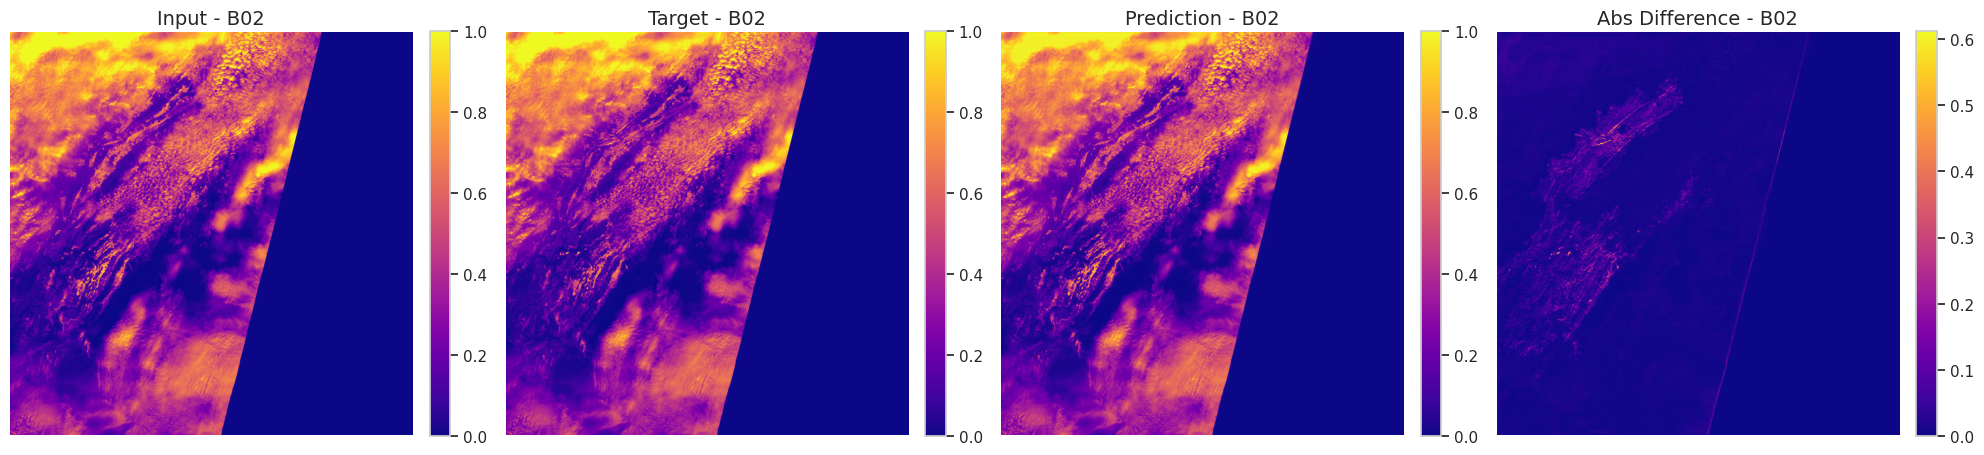

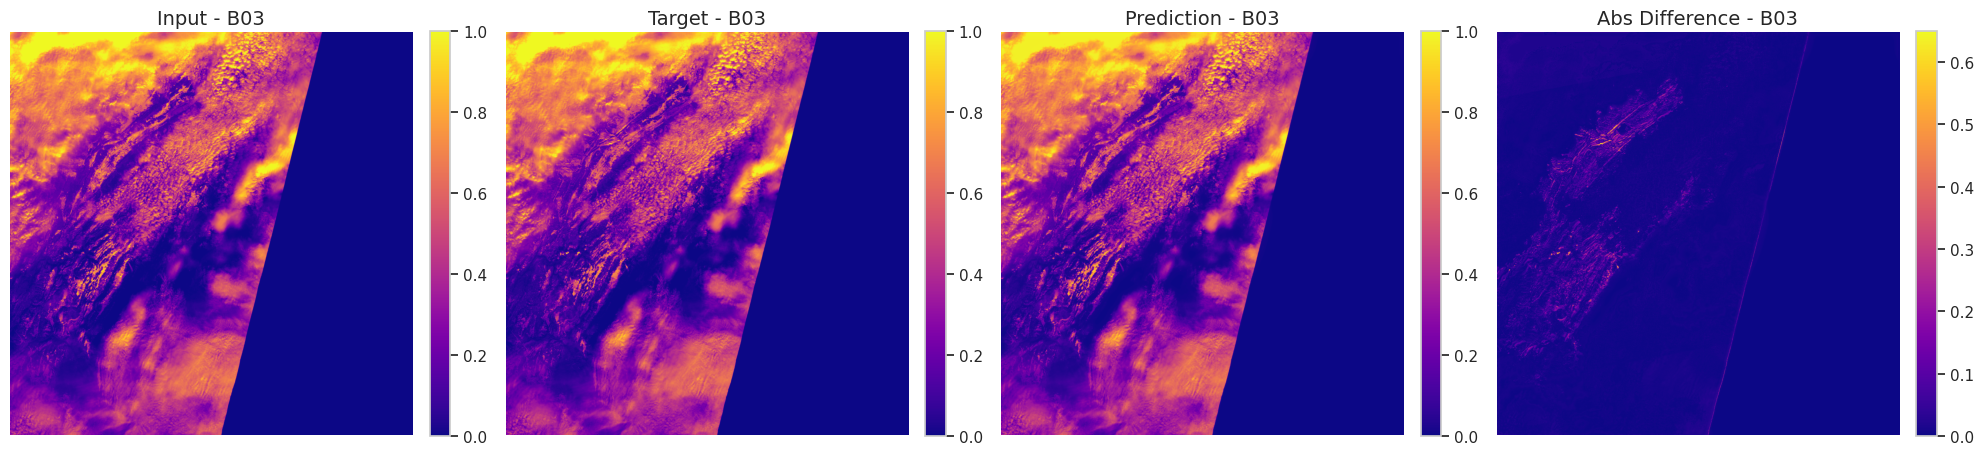

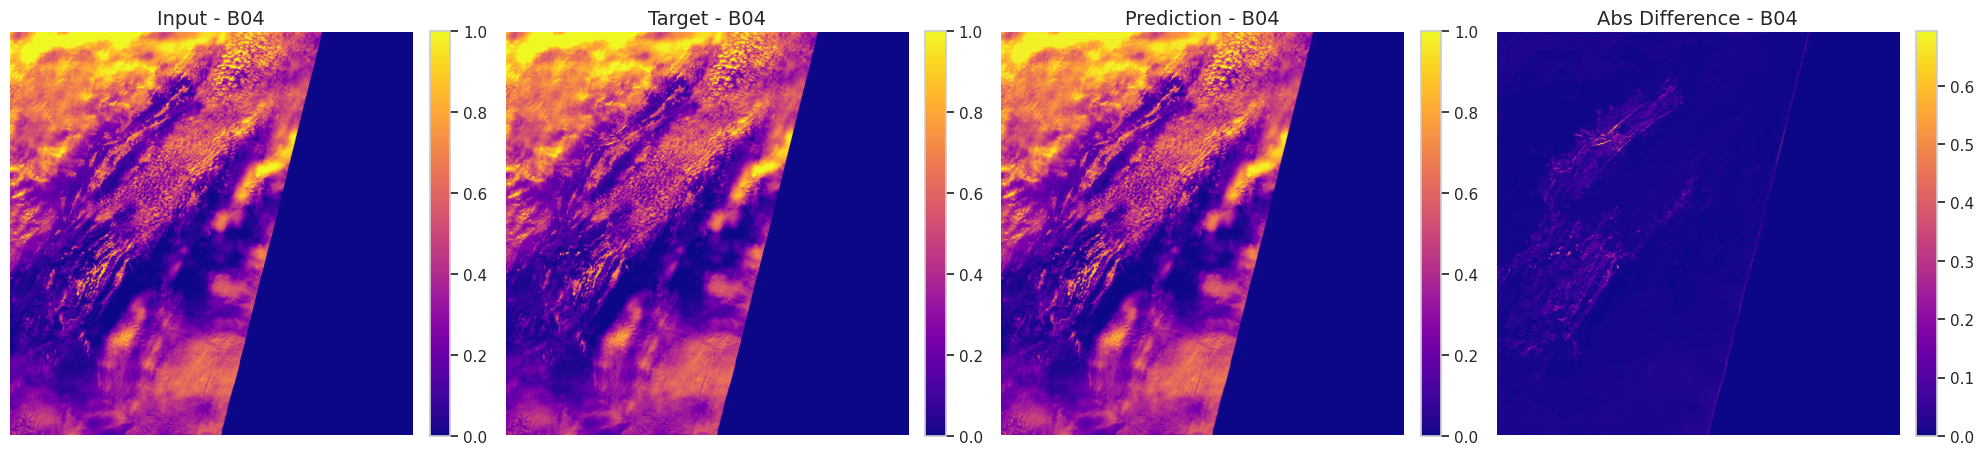

In [82]:
evaluate_and_plot(model, df_test_input, df_test_output, bands=bands, resize=resize, device=device, index=random_index, verbose=True, save=True, output_path=output_path)

## Plot SAM vs Cloud Coverage 

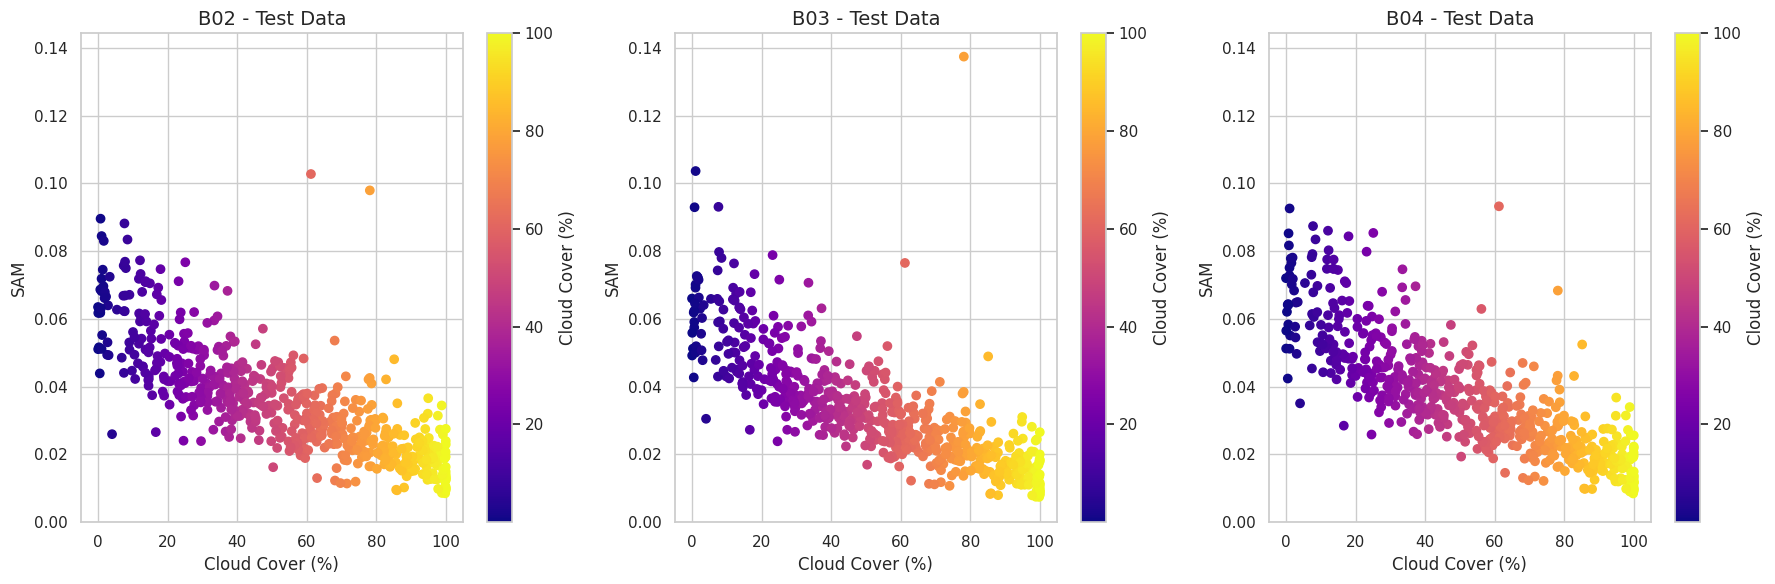

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import cm

# Set seaborn style
sns.set(style="whitegrid")

# Set up the figure (1 row x 3 columns)
fig, axs = plt.subplots(1, len(bands), figsize=(18, 6))

# Define the colormap
cmap = cm.plasma
# Find the global y-max to set consistent y-axis limits
global_ymax = 0
for band in bands:
    band_ymax = df_test_output[f'sam_{band}'].max()
    global_ymax = max(global_ymax, band_ymax)

# Add a small buffer (5%) for better visualization
global_ymax = global_ymax * 1.05

for i, band in enumerate(bands):
    ax = axs[i]  # Single row, 3 columns
    # Scatter plot for SAM with plasma colormap
    scatter = ax.scatter(
        data=df_test_output,
        x='cloud_cover',
        y=f'sam_{band}',
        c=df_test_output['cloud_cover'],  # Color by cloud_cover
        cmap=cmap  # Apply the plasma colormap
    )

    # Set title and labels
    ax.set_title(f"{band} - Test Data", fontsize=14)
    ax.set_xlabel("Cloud Cover (%)", fontsize=12)
    ax.set_ylabel("SAM", fontsize=12)
    ax.set_ylim(0, global_ymax)
    # Add colorbar
    plt.colorbar(scatter, ax=ax, label="Cloud Cover (%)")

plt.tight_layout()
plt.savefig(f"{mertrics_dir}/sam_vs_cloud_cover.svg")
plt.show()
plt.close()

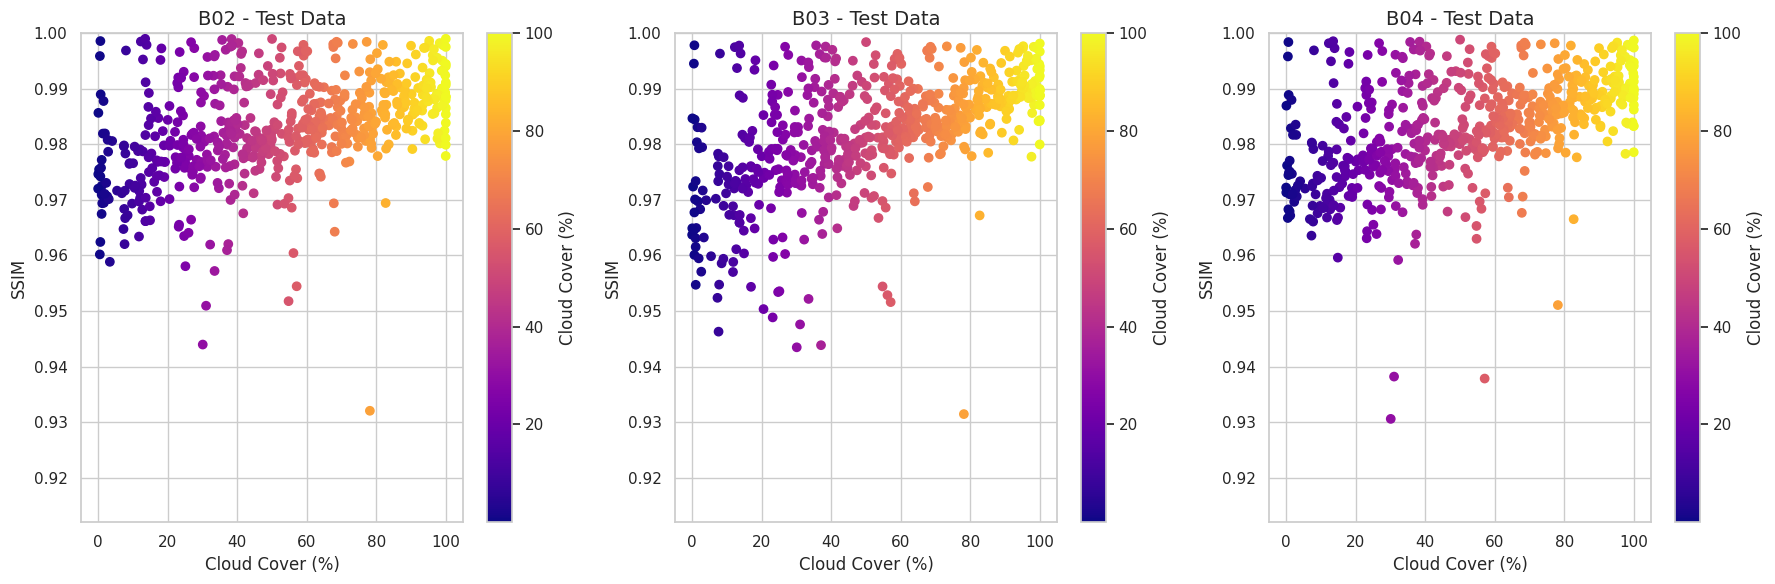

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import cm

# Set seaborn style
sns.set(style="whitegrid")

# Set up the figure (1 row x 3 columns)
fig, axs = plt.subplots(1, len(bands), figsize=(18, 6))

# Define the colormap
cmap = cm.plasma
# Find the global y-min to set consistent y-axis limits
# Initialize with a high value to find the minimum
global_ymin = 1.0  # Start with 1.0 since SSIM is normally ≤ 1
for band in bands:
    band_ymin = df_test_output[f'ssim_{band}'].min()
    global_ymin = min(global_ymin, band_ymin)

# Add a small buffer (5%) for better visualization
global_ymin = global_ymin * 0.98

for i, band in enumerate(bands):
    ax = axs[i]  # Single row, 3 columns

    # Scatter plot for SSIM with plasma colormap
    scatter = ax.scatter(
        data=df_test_output,
        x='cloud_cover',
        y=f'ssim_{band}',
        c=df_test_output['cloud_cover'],  # Color by cloud_cover
        cmap=cmap  # Apply the plasma colormap
    )

    # Set title and labels
    ax.set_title(f"{band} - Test Data", fontsize=14)
    ax.set_xlabel("Cloud Cover (%)", fontsize=12)
    ax.set_ylabel("SSIM", fontsize=12)
    ax.set_ylim(global_ymin, 1.0)

    # Add colorbar
    plt.colorbar(scatter, ax=ax, label="Cloud Cover (%)")

plt.tight_layout()
plt.savefig(f"{mertrics_dir}/ssim_vs_cloud_cover.svg")
plt.show()
plt.close()


## Plot SAM vs % Valid Pixel

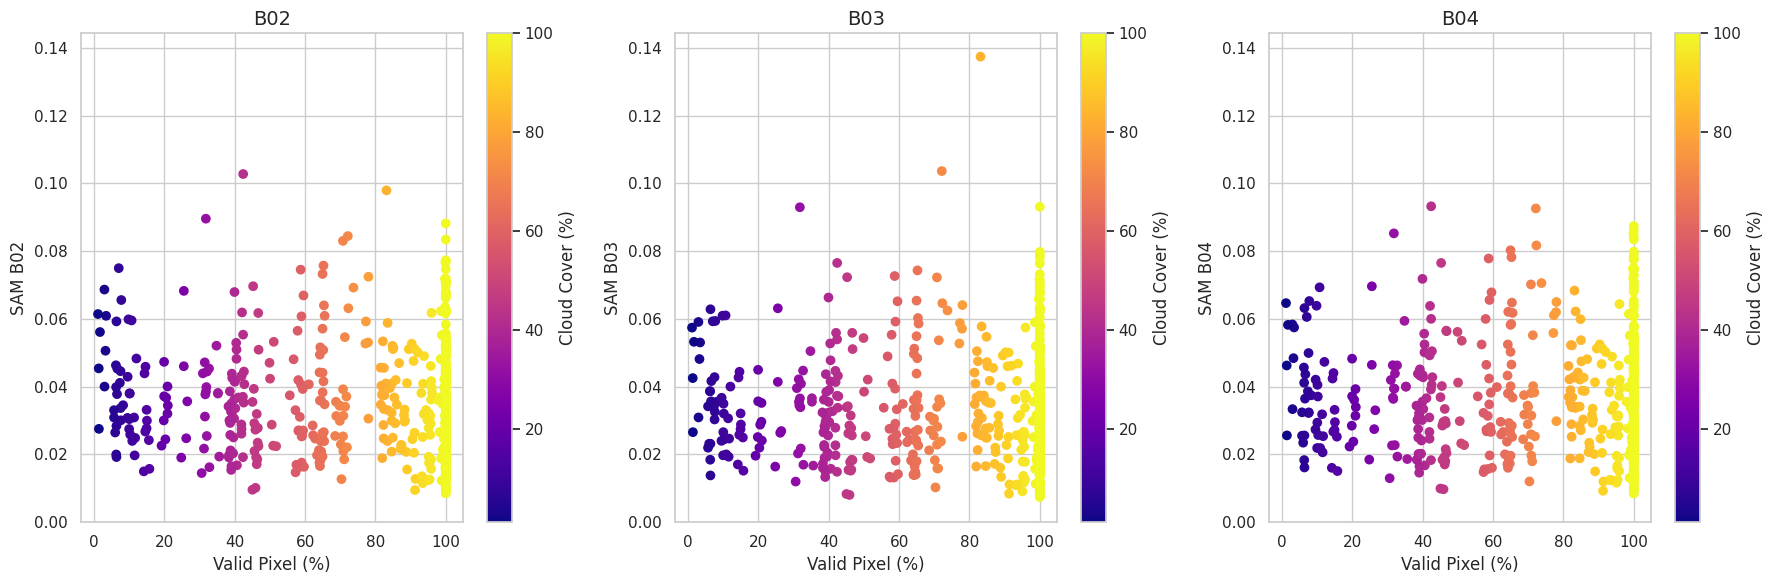

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import cm

# Set seaborn style
sns.set(style="whitegrid")

# Set up the figure (1 row x 3 columns)
fig, axs = plt.subplots(1, len(bands), figsize=(18, 6))

# Define the colormap
cmap = cm.plasma
global_ymax = 0
for band in bands:
    band_ymax = df_test_output[f'sam_{band}'].max()
    global_ymax = max(global_ymax, band_ymax)

# Add a small buffer (5%) for better visualization
global_ymax = global_ymax * 1.05

for i, band in enumerate(bands):
    ax = axs[i]  # Single row, 3 columns

    # Scatter plot for SAM with plasma colormap
    scatter = ax.scatter(
        data=df_test_output,
        x='valid_pixel',
        y=f'sam_{band}',
        c=df_test_output['valid_pixel'],  # Color by cloud_cover
        cmap=cmap  # Apply the plasma colormap
    )

    # Set title and labels
    ax.set_title(f"{band}", fontsize=14)
    ax.set_xlabel("Valid Pixel (%)", fontsize=12)
    ax.set_ylabel(f"SAM {band}", fontsize=12)
    ax.set_ylim(0, global_ymax)
    # Add colorbar
    plt.colorbar(scatter, ax=ax, label="Cloud Cover (%)")

plt.tight_layout()

plt.savefig(f"{mertrics_dir}/sam_vs_valid_pixel.svg")
plt.show()
plt.close()

## Valid Pixel vs Cloud Cover vs SAM 

In [87]:
import plotly.express as px
import plotly.graph_objects as go

# Create a 3D scatter plot
fig = px.scatter_3d(
    df_test_output,
    x='cloud_cover',
    y='valid_pixel',
    z='sam_B02',
    color='cloud_cover',  # Color points by cloud cover
    color_continuous_scale='plasma',  # Using plasma color scale to match your previous plot
    opacity=0.8,
    title='SAM B03 vs Cloud Cover vs Valid Pixels',
    labels={
        'cloud_cover': 'Cloud Cover (%)',
        'valid_pixel': 'Valid Pixels (%)',
        'sam_B03': 'SAM B03'
        }
)

# Update marker size
fig.update_traces(marker=dict(size=5))

# Customize layout
fig.update_layout(
    scene=dict(
        xaxis_title='Cloud Cover (%)',
        yaxis_title='Valid Pixels (%)',
        zaxis_title='SAM B03',
        xaxis=dict(gridcolor='lightgray'),
        yaxis=dict(gridcolor='lightgray'),
        zaxis=dict(gridcolor='lightgray'),
    ),
    width=900,
    height=700,
    margin=dict(l=0, r=0, b=0, t=30)
)
# Add colorbar title
fig.update_layout(coloraxis_colorbar=dict(title='Cloud Cover (%)'))
fig.write_html(f"{mertrics_dir}/sam_vs_valid_pixel_cloud_cover.html")

# Show the plot
fig.show()

## Identification of max SAM and PSNR with product investigation

In [24]:
# Find index where SSIM is minimum
min_ssim_idx = df_test_output[f'ssim_{band}'].idxmin()

# Find index where SAM is maximum
max_sam_idx = df_test_output[f'sam_{band}'].idxmax()

# Get the rows corresponding to these indices
min_ssim_row = df_test_output.loc[min_ssim_idx]
max_sam_row = df_test_output.loc[max_sam_idx]

# Print results
print(f"Index of minimum SSIM for {band}: {min_ssim_idx}, SSIM value: {min_ssim_row[f'ssim_{band}']}")
print(f"Index of maximum SAM for {band}: {max_sam_idx}, SAM value: {max_sam_row[f'sam_{band}']}")

Index of minimum SSIM for B04: 560, SSIM value: 0.5515009164810181
Index of maximum SAM for B04: 560, SAM value: 0.34029099345207214


## Minimum SSIM

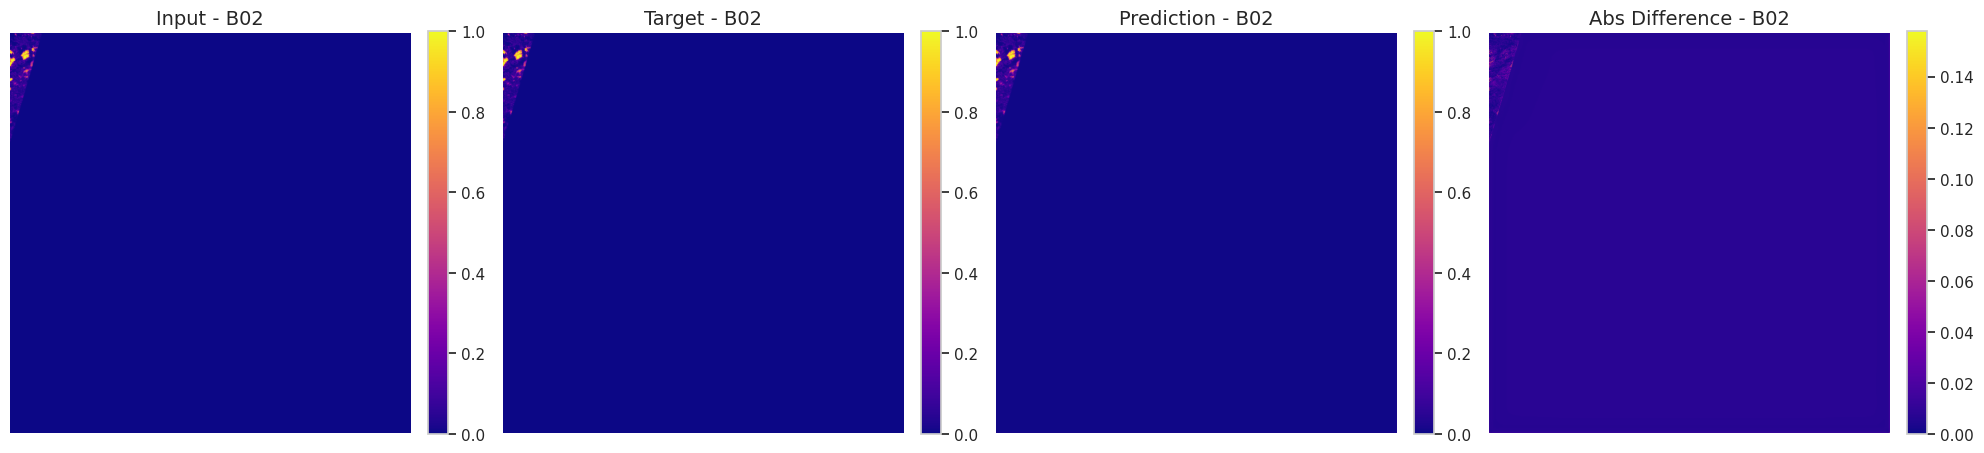

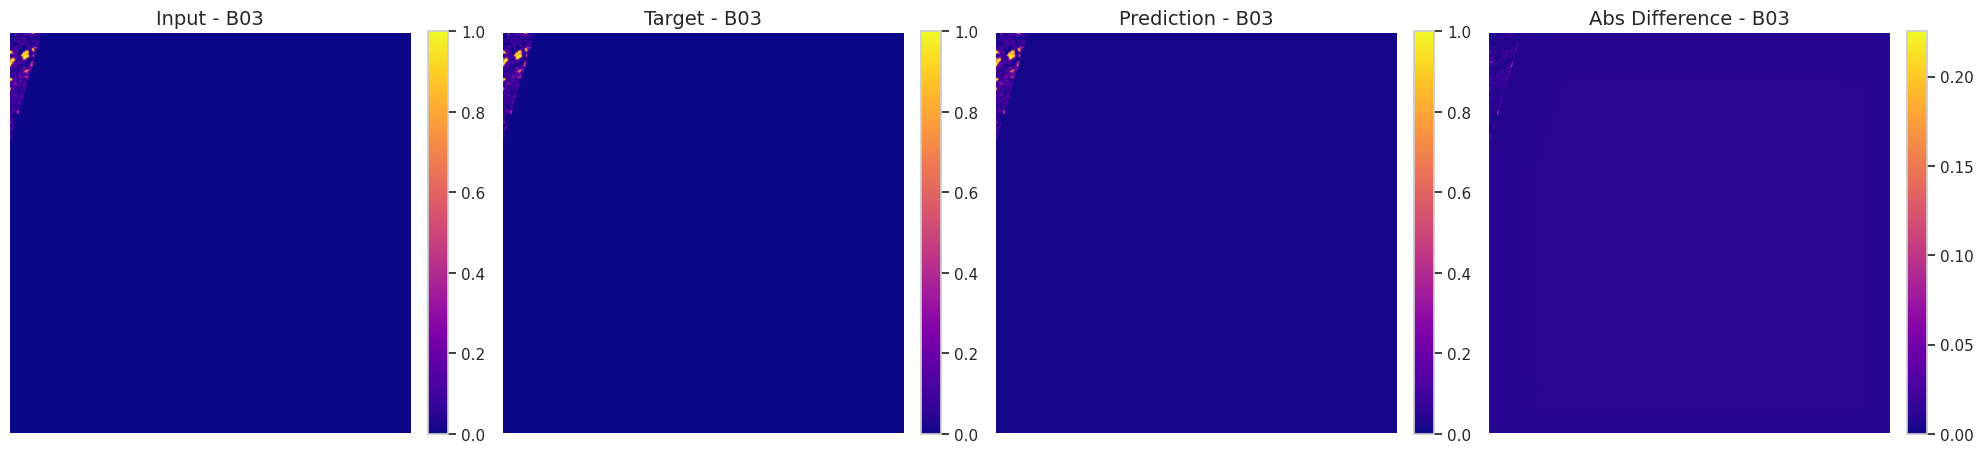

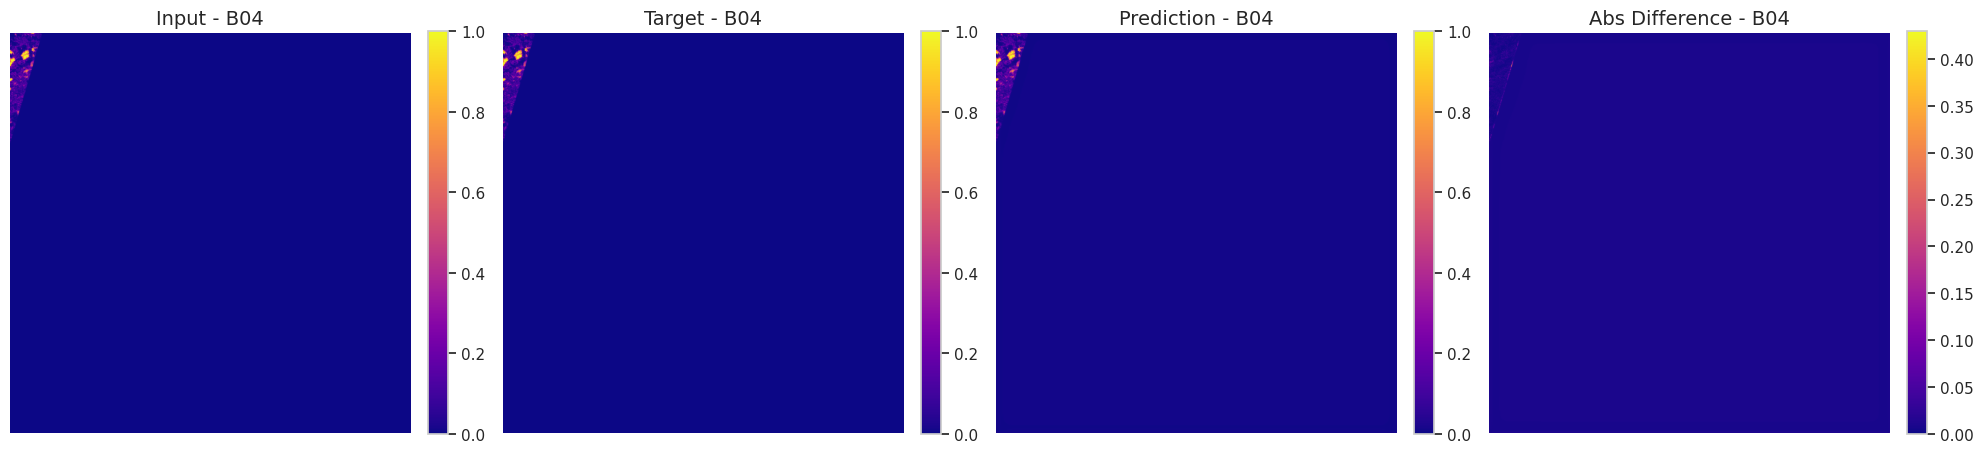

In [25]:
evaluate_and_plot(model, df_test_input, df_test_output, bands=bands, resize=resize, device=device, index=min_ssim_idx, verbose=True, save=False, output_path=output_path)

## maximum SAM

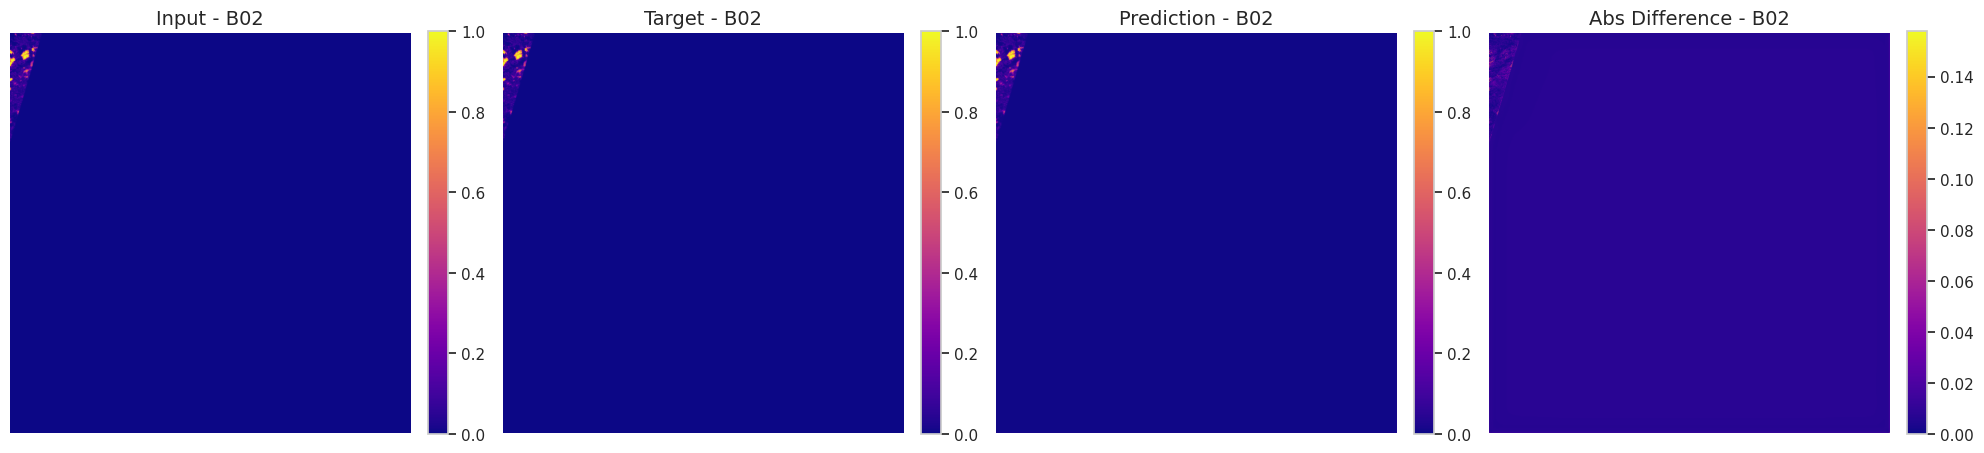

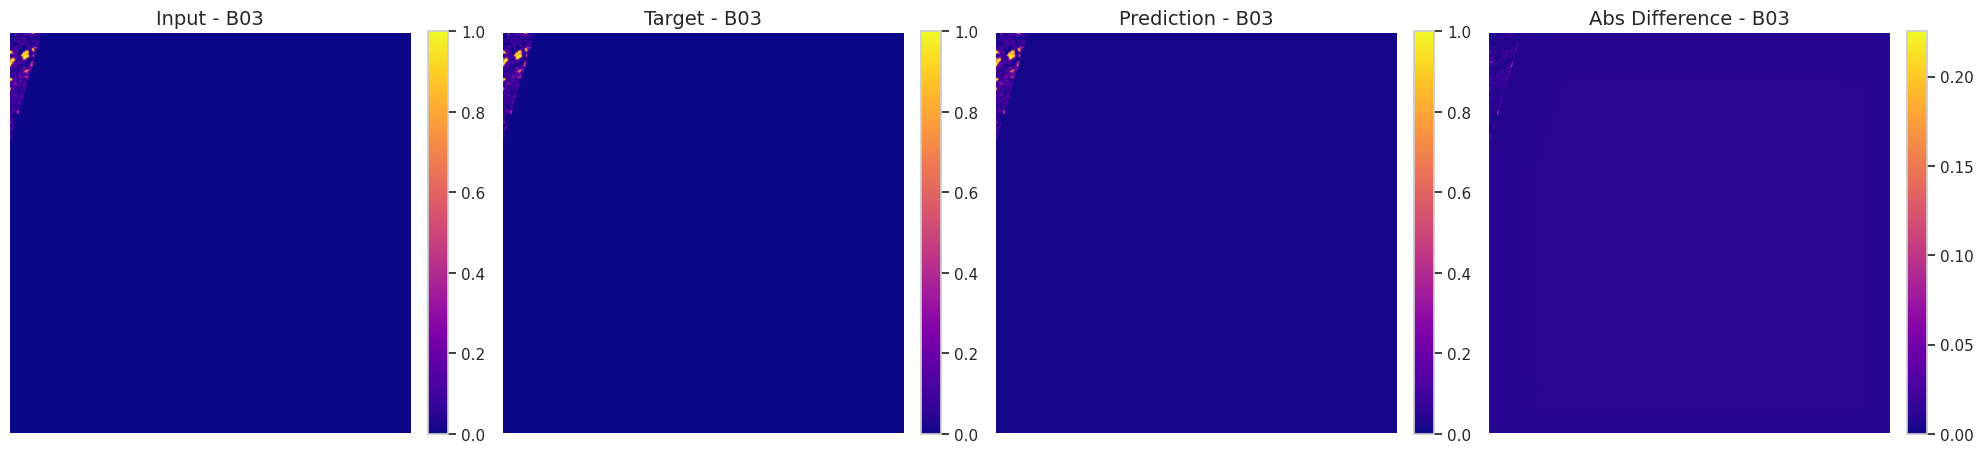

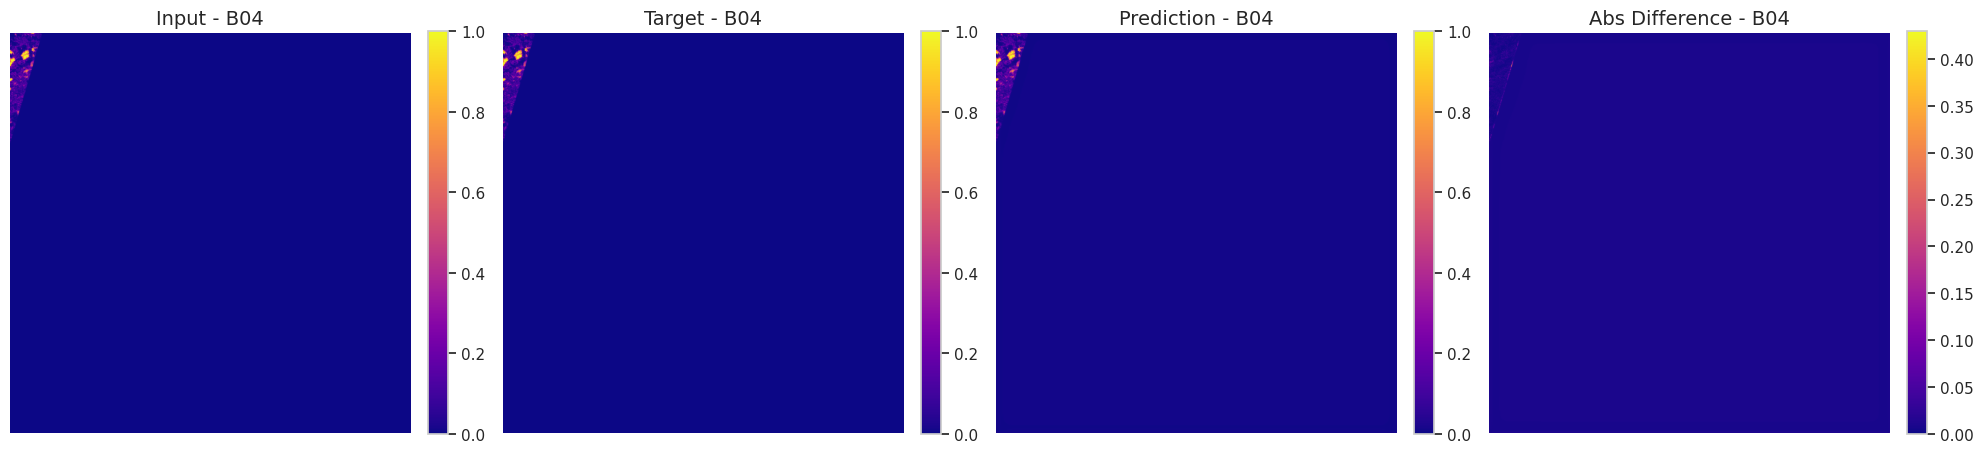

In [26]:
evaluate_and_plot(model, df_test_input, df_test_output, bands=bands, resize=resize, device=device, index=max_sam_idx, verbose=True, save=True, output_path=output_path)

## Top worst prediction

In [27]:
top_10_min_ssim_idx = df_test_output.sort_values(f'ssim_B02').head(10).index.tolist()
top_10_max_sam_idx = df_test_output.sort_values(f'sam_B02', ascending=False).head(10).index.tolist()

print(f"Top 10 indices with minimum SSIM for B02: {top_10_min_ssim_idx}")
print(f"Top 10 indices with maximum SAM for B02: {top_10_max_sam_idx}")


outputs_worst_path = f"{exp_dir}/{experience}/outputs_worst"
if not os.path.exists(outputs_worst_path):
    os.makedirs(outputs_worst_path)

Top 10 indices with minimum SSIM for B02: [560, 81, 536, 48, 290, 459, 339, 268, 596, 178]
Top 10 indices with maximum SAM for B02: [560, 81, 339, 22, 48, 391, 45, 459, 20, 536]


In [28]:
for idx in top_10_max_sam_idx:
    evaluate_and_plot(model, df_test_input, df_test_output, bands=bands, resize=resize, device=device, index=idx, verbose=False, save=True, output_path=outputs_worst_path)

In [29]:
top_10_max_ssim_idx = df_test_output.sort_values(f'ssim_B02').tail(20).index.tolist()
top_10_min_sam_idx = df_test_output.sort_values(f'sam_B02', ascending=False).tail(20).index.tolist()

print(f"Top 10 indices with maximum SSIM for B02: {top_10_max_ssim_idx}")
print(f"Top 10 indices with minimum SAM for B02: {top_10_min_sam_idx}")


output_best_path = f"{exp_dir}/{experience}/outputs_best"
if not os.path.exists(output_best_path):
    os.makedirs(output_best_path)

Top 10 indices with maximum SSIM for B02: [291, 8, 444, 540, 274, 19, 115, 4, 440, 122, 18, 514, 581, 124, 236, 214, 24, 413, 520, 371]
Top 10 indices with minimum SAM for B02: [399, 65, 415, 433, 129, 440, 371, 291, 489, 188, 236, 314, 19, 419, 112, 520, 567, 380, 18, 214]


In [30]:
for idx in top_10_min_sam_idx:
    evaluate_and_plot(model, df_test_input, df_test_output, bands=bands, resize=resize, device=device, index=idx, verbose=False, save=True, output_path=output_best_path)

In [31]:
import numpy as np

In [32]:
# import torch
# import torch.nn as nn
# import math

# class FlexibleWeightedLoss(nn.Module):
#     """
#     Flexible loss function weighted by valid pixel percentages.
#     Processes each channel separately and weights by sqrt(valid_pixel_percent).
#     Works with any base loss function provided.
#     """

#     def __init__(self, base_loss_fn, reduction='mean', valid_threshold=0):
#         """
#         Initialize the weighted loss.

#         Args:
#             base_loss_fn: Base loss function to apply to valid pixels
#                           Must accept two tensors and return a scalar loss
#             reduction: Specifies the reduction applied to the output
#                       'none': no reduction, 'mean': mean of losses, 'sum': sum of losses
#             valid_threshold: Pixels with target > valid_threshold are considered valid
#         """
#         super().__init__()
#         self.base_loss_fn = base_loss_fn
#         self.reduction = reduction
#         self.valid_threshold = valid_threshold

#     def forward(self, outputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
#         """
#         Calculate loss weighted by valid pixel percentages per channel.

#         Args:
#             outputs: Model predictions [B, C, H, W]
#             targets: Ground truth [B, C, H, W]

#         Returns:
#             Weighted loss value
#         """
#         batch_size, num_channels = outputs.shape[0], outputs.shape[1]
#         total_loss = 0.0
#         total_weight = 0.0

#         for b in range(batch_size):
#             for c in range(num_channels):
#                 # Extract single channel
#                 output_bc = outputs[b, c]
#                 target_bc = targets[b, c]

#                 # Create valid mask
#                 valid_mask = (target_bc > self.valid_threshold)

#                 # Skip if no valid pixels
#                 if not torch.any(valid_mask):
#                     continue

#                 # Calculate valid pixel percentage
#                 total_pixels = valid_mask.numel()
#                 valid_pixels = torch.sum(valid_mask).item()
#                 valid_ratio = valid_pixels / total_pixels
#                 print(valid_ratio)
#                 # Calculate weight: sqrt(valid_ratio)
#                 weight = math.sqrt(valid_ratio)

#                 # Calculate loss only on valid pixels
#                 if valid_pixels > 0:
#                     # Extract valid pixels
#                     output_valid = output_bc[valid_mask]
#                     target_valid = target_bc[valid_mask]

#                     # Calculate loss using provided base function
#                     channel_loss = self.base_loss_fn(output_valid, target_valid)

#                     # Add weighted loss
#                     total_loss += channel_loss * weight
#                     total_weight += weight

#         # Return loss based on reduction method
#         if total_weight > 0:
#             if self.reduction == 'none':
#                 return total_loss
#             elif self.reduction == 'sum':
#                 return total_loss
#             else:  # 'mean' is default
#                 return total_loss / total_weight
#         else:
#             return torch.tensor(0.0, device=outputs.device)


# class WeightedMSELoss(nn.Module):
#     """
#     MSE loss weighted by valid pixel percentages.
#     Only considers pixels where target > 0 as valid.
#     Weights each channel's contribution by sqrt(valid_pixel_percent)/100.
#     """

#     def __init__(self, reduction='mean'):
#         """
#         Initialize the weighted MSE loss.

#         Args:
#             reduction: Specifies the reduction applied to the output (for compatibility with nn.MSELoss)
#                        'none': no reduction, 'mean': mean of losses, 'sum': sum of losses
#         """
#         super().__init__()
#         self.reduction = reduction

#     def forward(self, outputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
#         """
#         Calculate MSE loss weighted by valid pixel percentages.

#         Args:
#             outputs: Model predictions [B, C, H, W]
#             targets: Ground truth [B, C, H, W]

#         Returns:
#             Weighted loss value
#         """
#         batch_size, num_channels = outputs.shape[0], outputs.shape[1]
#         total_loss = 0.0
#         total_weight = 0.0

#         for b in range(batch_size):
#             for c in range(num_channels):
#                 # Extract single channel
#                 output_bc = outputs[b, c]
#                 target_bc = targets[b, c]

#                 # Create valid mask
#                 valid_mask = (target_bc > 0)

#                 # Skip if no valid pixels
#                 if not torch.any(valid_mask):
#                     continue

#                 # Calculate valid pixel percentage
#                 total_pixels = valid_mask.numel()
#                 valid_pixels = torch.sum(valid_mask).item()
#                 valid_pixel_percent = (valid_pixels / total_pixels)

#                 print(valid_pixel_percent)

#                 # Calculate weight: sqrt(valid_pixel_percent)/100
#                 weight = math.sqrt(valid_pixel_percent)

#                 # Calculate MSE only on valid pixels
#                 if valid_pixels > 0:
#                     # Extract valid pixels
#                     output_valid = output_bc[valid_mask]
#                     target_valid = target_bc[valid_mask]

#                     # Calculate MSE
#                     mse = torch.mean((output_valid - target_valid) ** 2)
#                     # Add weighted loss
#                     total_loss += mse * weight
#                     total_weight += weight

#         # Return loss based on reduction method
#         if total_weight > 0:
#             if self.reduction == 'none':
#                 return total_loss
#             elif self.reduction == 'sum':
#                 return total_loss
#             else:  # 'mean' is default
#                 return total_loss / total_weight
#         else:
#             return torch.tensor(0.0, device=outputs.device)



In [33]:
# model.eval()
# # Create loss instances
# mse_loss_fn = nn.MSELoss(reduction='mean')
# flexible_criterion = FlexibleWeightedLoss(
#     base_loss_fn=lambda x, y: mse_loss_fn(x, y),  # Use nn.MSELoss instance
#     reduction='mean',
#     valid_threshold=0
# )

# weighted_mse_criterion = WeightedMSELoss(reduction='mean')

# with torch.no_grad():
#     with tqdm(total=len(test_loader.dataset), ncols=100, colour='#cc99ff') as t:
#         t.set_description("Testing")
#         for x_data, y_data in test_loader:
#             x_data, y_data = x_data.to(device), y_data.to(device)
#             outputs = model(x_data)

#             loss_1 = flexible_criterion(outputs, y_data).item()
#             loss_2 = weighted_mse_criterion(outputs, y_data).item()

#             if loss_1 != loss_2:
#                 print(f"WeightedMSELoss = {loss_2}")
#                 print(f"FlexibleWeightedLoss = {loss_1}")

#             t.update(x_data.size(0))
